### Upload a data

`X_train` - train image dataset
`Y_train` - train label dataset
`X_test` - test image dataset
`Y_test` - test label dataset

In [2]:
import tensorflow as tf
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display

In [3]:
import json
train_json = './Data_Sources/al5083/train/train.json'

with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

label_count = [0, 0, 0, 0, 0, 0]
for l in train_data_json:
    label_count[train_data_json[l]] += 1

label_count

[8758, 1783, 6325, 4028, 2953, 2819]

In [4]:
# Define names
label_names = ["good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration"]

# Define labels
labels = [0, 1, 2, 3, 4, 5]

# Number of classes
num_classes = 6

# Label is converted into a binary vector where only the position corresponding to the label is set to 1, and all other positions are set to 0.
one_hot_encoding_test = [[1 if i == label else 0 for i in range(num_classes)] for label in labels]

In [146]:
all_data = []
image_size = (16, 16)
label_count = [0, 0, 0, 0, 0, 0]

In [168]:
import os
def load_data(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):

                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data_json[key_name]

                if(label_count[label] > 400):
                    continue

                label_count[label] += 1
                image = Image.open(img_path).resize(image_size)
                #image = tf.convert_to_tensor(image)
                image = np.array(image, dtype=np.int32)
                all_data.append((image, label))

                if(len(all_data)%100==0):
                    print(f"Total images loaded : {len(all_data)}, Label count : {label_count}", end = '\r')

In [164]:
load_data('./Data_Sources/al5083/train')

In [165]:
random.shuffle(all_data)

In [166]:
X = []
Y = []
for data in all_data:
    X.append(data[0])
    Y.append(data[1])

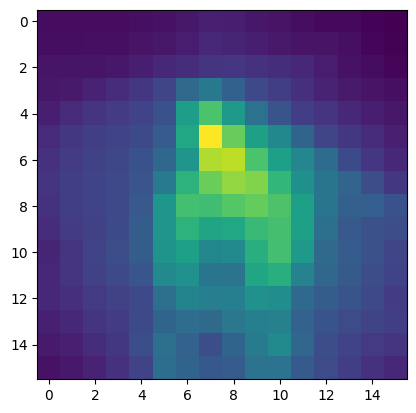

Label : contamination


In [150]:
import matplotlib.pyplot as plt
rand_img = np.random.randint(low = 0, high = len(X))
print(f"Label : {label_names[Y[rand_img]]}")
plt.imshow(X[rand_img])
plt.show()

print(f"Label : {label_names[Y[rand_img]]}")

Split the data into training sets: 80% of the total data for training

In [151]:
# Split the data into : 80% of the total data for training,20% of the total data for testing
total_data = len(X)
X_train, Y_train = X[:int(total_data*0.8)], Y[:int(total_data*0.8)]
X_test, Y_test = X[int(total_data*0.8):], Y[int(total_data*0.8):]

This means converting the 2D array of image pixels (16x16 pixels) into a 1D array.

In [152]:
# This means converting the 2D array of image pixels (16x16 pixels) into a 1D array.
# Reshape each image in X_train to 1D array
X_train = np.array([x.reshape(-1) for x in X_train])

# Reshape each image in X_test to 1D array
X_test = np.array([x.reshape(-1) for x in X_test])

Training set:

In [153]:
values, counts = np.unique( Y_train, return_counts=True)
print(values)
print(counts)

[0 1 2 3 4 5]
[331 331 315 310 320 317]


Testing set:

In [154]:
values, counts = np.unique(Y_test, return_counts=True)
print(values)
print(counts)

[0 1 2 3 4 5]
[70 70 86 91 81 84]


### Model

PEPS architecture - circuit

(<Figure size 1800x900 with 1 Axes>, <Axes: >)

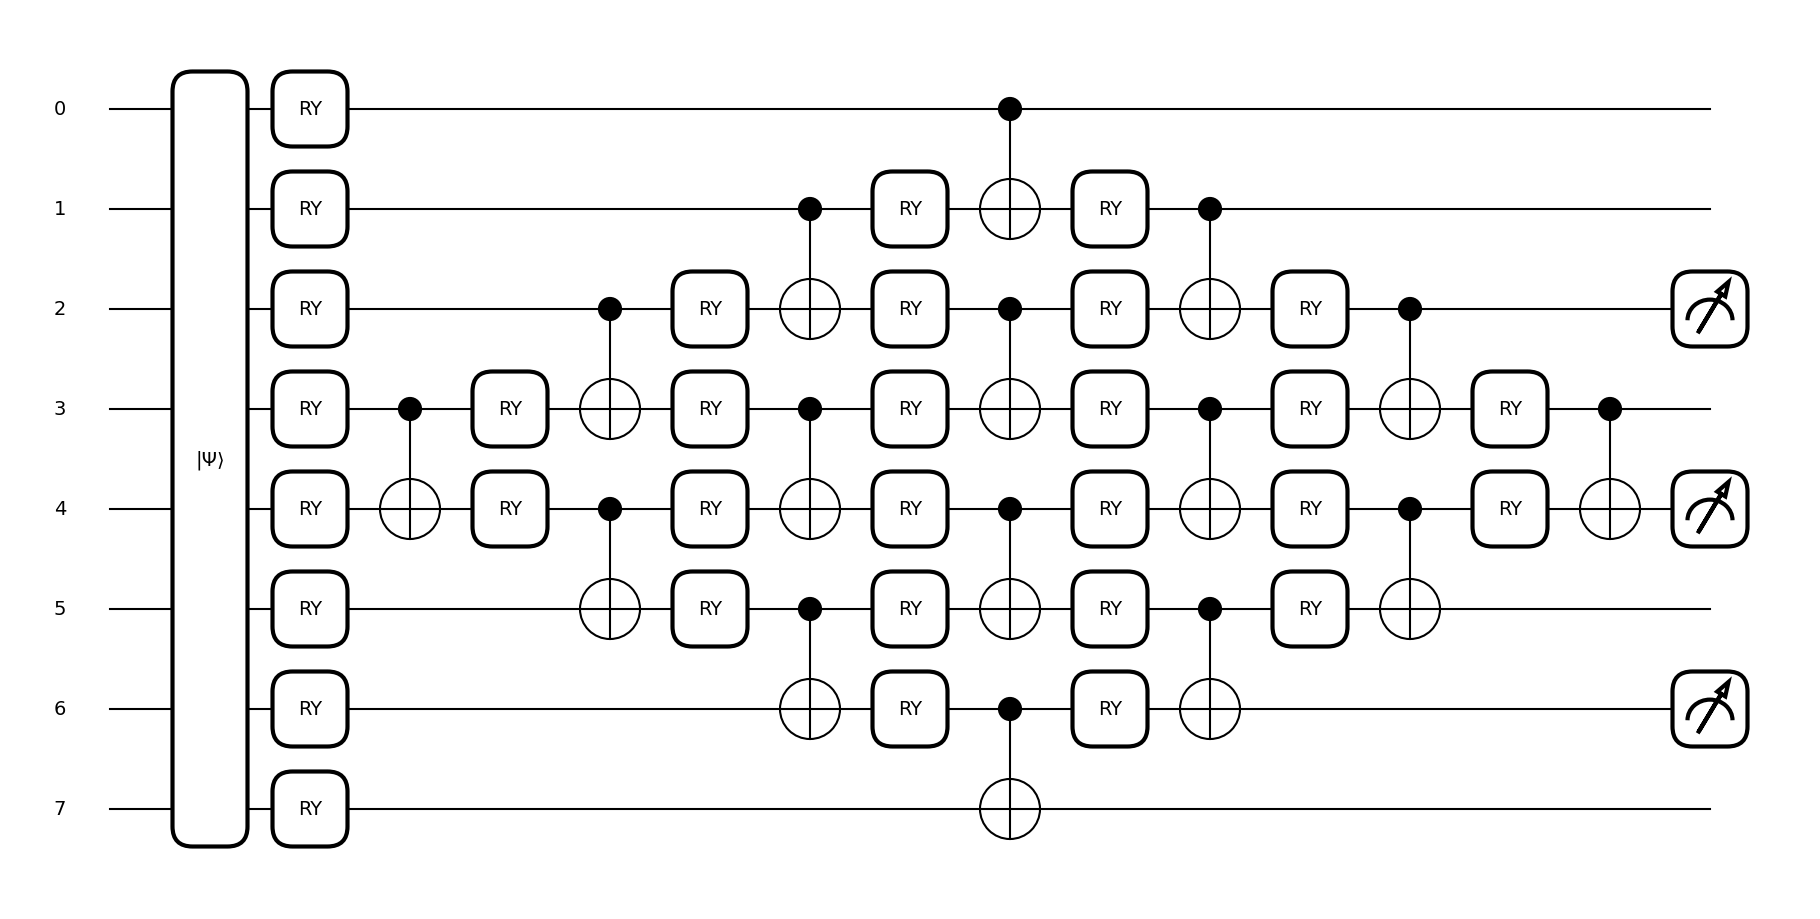

In [169]:
import pennylane as qml
from pennylane import numpy as np
dev = qml.device("default.qubit", wires=8)

@qml.qnode(dev)
def circuit_peps(image, template_weights):
    qml.AmplitudeEmbedding(features=image, wires=range(8), normalize=True)

    i = 0

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(0, 7, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    # qml.probs(wires =[1,3,5]) [3,5,7]
    return qml.probs(wires = [2,4,6])
    # return qml.probs(wires =[1,3,5])

weights = np.random.random(size=[32, 1])
qml.draw_mpl(circuit_peps, expansion_strategy="device")(X_train[0], weights)
#circuit_peps(X_train[0], weights)

Cost function with Cross-Entropy Loss

In [110]:
len(X_train[0])

256

In [111]:
def generate_batch(X_train, Y_train, batch_size):
    # Generate random indices for the batch
    batch_index = np.random.randint(0, len(X_train), batch_size)

    # Create X_batch and Y_batch sets using list comprehensions
    X_batch = [X_train[idx] for idx in batch_index]
    Y_batch = [Y_train[idx] for idx in batch_index]

    # Convert the lists to numpy arrays
    X_batch = np.array(X_batch, dtype = 'float')
    Y_batch = np.array(Y_batch, dtype = 'float')

    return X_batch, Y_batch

In [156]:
def costfunc(params):
    cost = 0
    y_true = [np.array([1, 0, 0, 0, 0,0,0,0]), np.array([0, 1, 0, 0, 0,0,0,0]), np.array([0, 0, 1, 0, 0,0,0,0]), np.array([0, 0, 0, 1, 0,0,0,0]),np.array([0, 0, 0, 0, 1,0,0,0]), np.array([0, 0, 0, 0, 0,1,0,0])]
    #X_batch, Y_batch = generate_batch(X_train, Y_train, batch_size = 400)
    X_batch, Y_batch = X_train, Y_train
    len_X = len(X_batch)
    for i in range(len_X):
        prob = circuit_peps(X_batch[i], params)
        if Y_batch[i] == 0:
            cost -= 1/len_X * np.sum(np.sum(y_true[0].astype(float)*np.log(prob.astype(float))))
        elif Y_batch[i] == 1:
            cost -= 1/len_X * np.sum(np.sum(y_true[1].astype(float)*np.log(prob.astype(float))))
        elif Y_batch[i] == 2:
            cost -= 1/len_X * np.sum(np.sum(y_true[2].astype(float)*np.log(prob.astype(float))))
        elif Y_batch[i] == 3:
            cost -= 1/len_X * np.sum(np.sum(y_true[3].astype(float)*np.log(prob.astype(float))))
        elif Y_batch[i] == 4:
            cost -= 1/len_X * np.sum(np.sum(y_true[4].astype(float)*np.log(prob.astype(float))))
        elif Y_batch[i] == 5:
            cost -= 1/len_X * np.sum(np.sum(y_true[5].astype(float)*np.log(prob.astype(float))))
    return cost

training the circuit parameters

In [83]:
X_batch, Y_batch = generate_batch(X_train, Y_train, batch_size = 128)

len_X = len(X_batch[0])
len_X

256

In [90]:
# training the circuit parameters
x2 = np.random.random(size=[32, 1], requires_grad=True)
params = x2[:]
X_batch, Y_batch = generate_batch(X_train, Y_train, batch_size = 600)
costfunc(params)

tensor(2.01236392, requires_grad=True)

In [157]:
# training the circuit parameters
x2 = np.random.random(size=[32, 1], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.1)

for k in range(50):
    #print(f"Step {k}, cost: {costfunc(params)}")
    params,cost = optimizer.step_and_cost(costfunc, params)
    print(f"Step {k}, cost: {cost}")
print(params)

Step 0, cost: 2.1182137179511518
Step 1, cost: 1.980390968843335
Step 2, cost: 1.9699374661723494
Step 3, cost: 1.943611636409588
Step 4, cost: 1.8808927641217525
Step 5, cost: 1.8143942931518942
Step 6, cost: 1.7751394277266013
Step 7, cost: 1.767404200678912
Step 8, cost: 1.7609074842095511
Step 9, cost: 1.7413037630158783
Step 10, cost: 1.72064854809109
Step 11, cost: 1.7139586706880139
Step 12, cost: 1.7188263474940848
Step 13, cost: 1.7219456469365104
Step 14, cost: 1.7194681754541208
Step 15, cost: 1.7142586547545642
Step 16, cost: 1.7094331534289615
Step 17, cost: 1.7059489282477869
Step 18, cost: 1.7019452147629452
Step 19, cost: 1.6953172541145394
Step 20, cost: 1.6870134176849396
Step 21, cost: 1.6802660039420674
Step 22, cost: 1.6767044931159882
Step 23, cost: 1.674410334943488
Step 24, cost: 1.6707196429384295
Step 25, cost: 1.665501042537575
Step 26, cost: 1.660790539858292
Step 27, cost: 1.6583002453944624
Step 28, cost: 1.6577893413354208
Step 29, cost: 1.657682499374173

### Checking the circuit on first X_test data.

In [115]:
x = circuit_peps(X_test[0], params)
np.argmax(x)

2

In [116]:
Y_test[0]

0

### Calculating accuracy
On the test set extracted from the training set. When predicted_label does not match test_label, both values are displayed.

In [158]:
test_correct = 0

for img, true_label in zip(X_test, Y_test):
    # Get predictions from the quantum circuit
    predictions = circuit_peps(img, params)

    # Determine the predicted label
    predicted_label = np.argmax(predictions)

    # Increment correct count if prediction matches the true label
    if predicted_label == true_label:
        test_correct += 1
    else:
        print("Predicted label:", predicted_label)
        print("True label",true_label)

# Calculate and print the testing accuracy percentage
accuracy = 100 * test_correct / len(X_test)
print(f"Testing accuracy: {accuracy:.2f}%")

Predicted label: 1
True label 3
Predicted label: 1
True label 3
Predicted label: 1
True label 5
Predicted label: 0
True label 4
Predicted label: 3
True label 2
Predicted label: 1
True label 3
Predicted label: 0
True label 4
Predicted label: 0
True label 4
Predicted label: 1
True label 3
Predicted label: 0
True label 1
Predicted label: 0
True label 5
Predicted label: 0
True label 4
Predicted label: 0
True label 4
Predicted label: 1
True label 3
Predicted label: 1
True label 3
Predicted label: 0
True label 4
Predicted label: 0
True label 4
Predicted label: 1
True label 3
Predicted label: 1
True label 3
Predicted label: 0
True label 4
Predicted label: 1
True label 3
Predicted label: 1
True label 5
Predicted label: 1
True label 5
Predicted label: 1
True label 3
Predicted label: 1
True label 3
Predicted label: 0
True label 4
Predicted label: 0
True label 1
Predicted label: 3
True label 1
Predicted label: 0
True label 4
Predicted label: 0
True label 4
Predicted label: 1
True label 3
Predicte

We can see that it is most often mistaken in recognizing class 1. The model says it is 3 when in fact it is 1.

### Summary  Experiment 1
Classification for 4 class, PEPS circuit.
Using 400 images from train dataset.
Training set: images [73 82 86 82] per classes [0 1 2 3]
Testing set: images [28 19 15 19] per classes [0,1,2,3]


Testing accuracy: 91.36%


### Summary Experiment 2
Classification for 6 class, PEPS circuit.
Using 600 images from train dataset.
Training set: images [78 78 88 81 78 81] per classes [0 1 2 3 4 5]
Testing set: images [23 23 13 20 23 20] per classes [0 1 2 3 4 5]
Without batches.
Epoch: 50
Testing accuracy: 63.11%

### Summary Experiment 3
Classification for 6 class, PEPS circuit.
Using 2400 images from train dataset.
Training set: images [331 331 315 310 320 317] per classes [0 1 2 3 4 5]
Testing set: images [70 70 86 91 81 84] per classes [0 1 2 3 4 5]
Without batches.
Epoch: 50
Time: almost 2h
Testing accuracy: 47.51%